# Unsupervised Deep Learning Tutorial 1.2

In this part of the tutorial we will look at the Self-Attention mechanism in Transformers and how they can be trained in a self-supervised autoregressive fashion to predict time series.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random as rd
import math
from typing import Tuple, Optional

torch.manual_seed(0)
rd.seed(0)

## Toy Time Series Data

We will be reusing the same toy time series from the previous part of the tutorial

In [2]:
def generate_toy_time_series(batch_size: int = 5, sequence_length: int = 100) -> Tuple[torch.Tensor, torch.Tensor]:

    t = torch.linspace(0, 1, sequence_length)

    # Create the sequences
    # Each one has a varying phase between 0 and 2pi
    # And a random frequency between 0 and 2pi
    # Feel free to play around with these parameters!
    sequences = []
    for sample in range(batch_size):
        phase = rd.random() * 2 * torch.pi
        frequency = rd.random() * 2 * torch.pi
        sequence = torch.sin(t * frequency + phase)
        sequences.append(sequence)

    # (batch_size, sequence_length) -> (batch_size, suquence_length, input_size)
    # Since each of our time series has a single feature, namely sin(t), out input_size is 1
    sequences = torch.stack(sequences).unsqueeze(-1)
    
    # Observations
    X = sequences[:, :-1]
    
    # Labels (observations shifted by one)
    y = sequences[:, 1:]
    
    return X, y

torch.Size([10, 99, 1]) torch.Size([10, 99, 1])


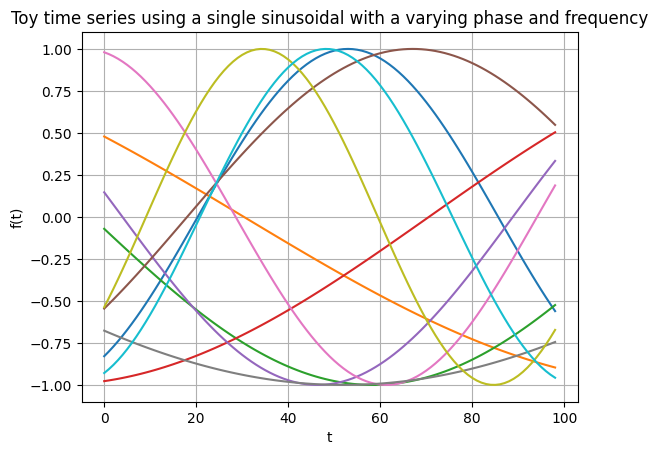

In [3]:
X, y = generate_toy_time_series(batch_size=10, sequence_length=100)
print(X.shape, y.shape)
for sample in X:
    plt.plot(sample.squeeze())
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('Toy time series using a single sinusoidal with a varying phase and frequency')
plt.grid()
plt.show()

In [4]:
_, t, d = X.shape

## The Masked Self-Attention Layer

Formally, the forward pass of the Self-Attention Layer is defined as follows:

\begin{align}
\tag{1} & [Q,K,V]=XU_{qkv}\\
\tag{2} & A = \text{softmax}\left(\frac{QK^\top}{\sqrt{p}}\right)V \\
\tag{3} & Y = AW^{\text{output}}
\end{align}

- Input: $X\in\mathbb{R}^{t\times d}$, the sequence of $t$ time steps, where each time step is a $d$-dimensional feature vector
- Output: $Y\in\mathbb{R}^{t\times d}$, where $Y_i$ is the prediction for time step $i-1$
- Learnable weights $U\in\mathbb{R}^{d\times(2p+q)}$ are used to compute the queries $Q\in\mathbb{R}^{t\times p}$, the keys $K\in\mathbb{R}^{t\times p}$, and the values $V\in\mathbb{R}^{t\times q}$ given the input $X$.
- The $\text{softmax}$ function is applied row-wise.
- Learnable weights $W^{\text{output}}\in\mathbb{R}^{q\times d}$ are used to project $A$ back to the input space

First of all, the attention operation is *permutation-invariant*, meaning that no matter how we shuffle the timesteps (i.e. the rows of $X$), we always end up with the same output. To circumvent this, we can add a learnable positional embedding $E^{\text{pos}}\in\mathbb{R}^{t\times d}$ as follows:

$$
X \gets X + E^{\text{pos}}
$$

Using PyTorch, we can implement this as follows:

In [5]:
class CustomEmbedding(nn.Module):
    def __init__(self, t: int, d: int = 1) -> None:
        
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(1, t, d)) # The extra 1 is added to broadcast over the whole batch

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x_with_positional_embedding = x + self.positional_embedding
        return x_with_positional_embedding

In [6]:
positional_embedding = CustomEmbedding(t=t, d=d)

Now we can implement the attention layer. Normally, the attention layer preprocesses the whole sequence at once, meaning that time step $t$ could attend to time step $t^\prime>t$. This is useful for processing text and images but in time series it is cheating since we are essentially using the future to learn the past, even though the future is unknown. To circumvent this, we use **masking**, i.e. ensuring that $A_{ij}=0$ if $j>i$. The rest is simply applying the equations from above.

In [7]:
class CustomMaskedSelfAttention(nn.Module):
    
    def __init__(self, t: int, d: int = 1, p: int = 1, q: int = 1) -> None:
        
        super().__init__()
        self.d = d
        self.p = p
        self.q = q
        self.Uqkv = nn.Linear(d, 2*p+q)
        self.Woutput = nn.Linear(q, d)
        self.mask = torch.tril(torch.ones(1, t, t)).bool() # Extra 1 -> broadcast over the whole batch
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Compute the queries, keys, and values:
        # Q and K are (batch_size, t, p) matrices, while the values are (batch_size, t, q)
        Q, K, V = self.Uqkv(x).split((self.p, self.p, self.q), dim=2)

        # Compute the scaled dot product attention scores
        # Shape: (batch_size, t, t)
        attention_scores: torch.Tensor = (Q @ K.mT) / math.sqrt(self.p)
        
        # Apply masking. Important to set the invalid values to -inf instead of 0
        # as the softmax would convert -inf to 0
        masked_attention_scores = attention_scores.masked_fill(~self.mask, float('-inf'))
        
        # Compute the attention weights by applying the softmax function row-wise
        attention_weights = F.softmax(masked_attention_scores, dim=2)

        # Take the weighted average of the values using the computed weights
        weighted_sum = attention_weights @ V

        # Project them back to the input space
        weighted_sum_projection = self.Woutput(weighted_sum)
        
        return weighted_sum_projection

As you can notice, the implementation does not contain a loop over the time steps, which is contrary to LSTMs. That is a big advantage of transformers, they can process the whole sequence at once! 

As it has been discussed in the lecture, the attention operation is *linear*. To account for this, we can attach a simple MLP after the attention layer. Here we can also make use of layer normalization and residual connections, as discussed in the lecture.

In [8]:
class CustomTransformerBlock(nn.Module):
    
    def __init__(self, t: int, d: int = 1, p: int = 1, q: int = 1) -> None:
        
        super().__init__()
        self.attention = CustomMaskedSelfAttention(t, d, p, q)
        self.mlp = nn.Sequential(
            nn.Linear(d, d*4),
            nn.ReLU(),
            nn.Linear(d*4, d)
        )
        self.layer_norm1 = nn.LayerNorm(d)
        self.layer_norm2 = nn.LayerNorm(d)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
    
        x = x + self.attention(self.layer_norm1(x))
        x = x + self.mlp(self.layer_norm2(x))
        return x

And we are already done! As it can be seen, the shape of the input and output of the transformer block have the same shape. Therefore, we can easily stack multiple transformer blocks on top of each other, similarly to the LSTMs. Now let's combine it with the embedding and give it a go!

## Training

In [9]:
model = nn.Sequential(positional_embedding, CustomTransformerBlock(t=t, d=d))
print(model)
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')

Sequential(
  (0): CustomEmbedding()
  (1): CustomTransformerBlock(
    (attention): CustomMaskedSelfAttention(
      (Uqkv): Linear(in_features=1, out_features=3, bias=True)
      (Woutput): Linear(in_features=1, out_features=1, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=1, out_features=4, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4, out_features=1, bias=True)
    )
    (layer_norm1): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    (layer_norm2): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
  )
)
Total number of parameters: 124


In [10]:
with torch.inference_mode():
    y_test = model(X)
y_test.shape

torch.Size([10, 99, 1])

Looks like it works! We can apply the exact same training process as with the LSTMs

In [11]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

In [12]:
for i in range(1001):
    preds = model(X)
    loss = loss_fn(y, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%100 == 0: print(f'Epoch: {i} | Loss: {loss.item():.4f}')

Epoch: 0 | Loss: 1.2901
Epoch: 100 | Loss: 0.2450
Epoch: 200 | Loss: 0.0662
Epoch: 300 | Loss: 0.0190
Epoch: 400 | Loss: 0.0057
Epoch: 500 | Loss: 0.0020
Epoch: 600 | Loss: 0.0011
Epoch: 700 | Loss: 0.0009
Epoch: 800 | Loss: 0.0008
Epoch: 900 | Loss: 0.0008
Epoch: 1000 | Loss: 0.0008


Nice! Our model is learning and it is going way faster then the LSTM! Let us again visualize the training results (everything is the same as in the LSTM)

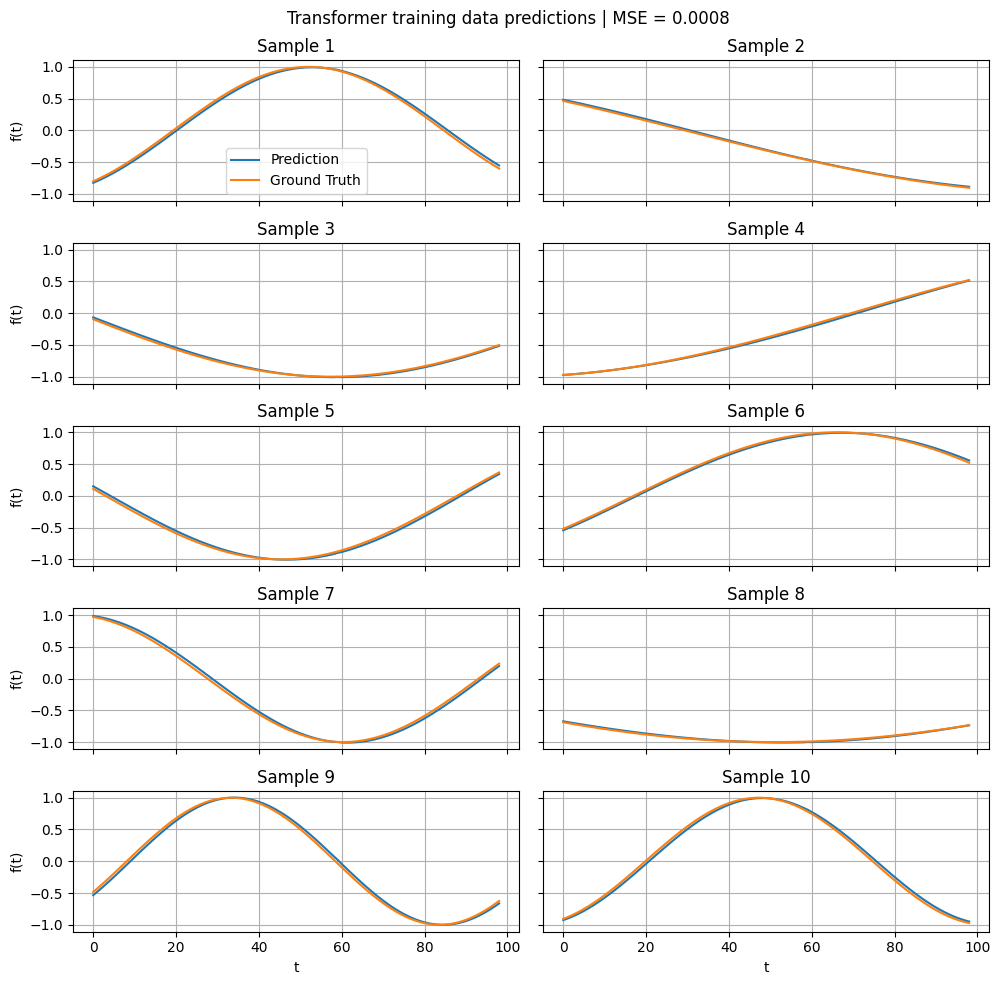

In [13]:
fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10, 10))
ax[-1][0].set_xlabel('t')
ax[-1][1].set_xlabel('t')
for a in ax[:, 0]:
    a.set_ylabel('f(t)')
ax = ax.flatten()
with torch.inference_mode():
    predictions = model(X)
for i, (sample, prediction, ground_truth, a) in enumerate(zip(X, predictions, y, ax)):
    a.plot(prediction.squeeze(), label='Prediction')
    a.plot(ground_truth.squeeze(), label='Ground Truth')
    a.grid()
    a.set_title(f'Sample {i+1}')
ax[0].legend()
plt.suptitle(f'Transformer training data predictions | MSE = {loss.item():.4f}')
plt.tight_layout()
plt.show()

## Evaluation

The training data is fit perfectly! Let's look at a test example:

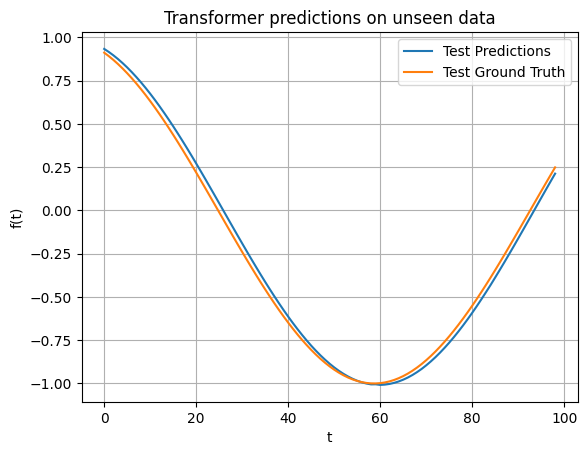

In [14]:
X_test, y_test = generate_toy_time_series(batch_size=1, sequence_length=100)
with torch.inference_mode():
    test_predictions = model(X_test)
plt.plot(test_predictions.squeeze(), label='Test Predictions')
plt.plot(y_test.squeeze(), label='Test Ground Truth')
plt.title('Transformer predictions on unseen data')
plt.legend()
plt.xlabel('t')
plt.ylabel('f(t)')
plt.grid()
plt.show()

Looks great! It is important to keep in mind here that the tasks is extremely simple and using attention is likely an overkill. An attractive property of the transformers is their scalability, which makes them useful for complicated tasks such as language modelling. Therefore, to justify the use of transformers, one would require a huge task with many and long sequences. In practice, training transformers for such tasks is very expensive so most of the time we can use pretrained models such as from HuggingFace like the `TimeSeriesTransformer`, [link](https://huggingface.co/docs/transformers/model_doc/time_series_transformer).

## Your Tasks

Here are 3 possible tasks to get to know transformers better.

1. Similarly to LSTMs, transformers typically do not require the full $t$ time steps to make a prediction, the $t$ is just an upper bound. You can also notice that none of the learnable parameters are dependent on $t$ other than the positional encoding $E^{\text{pos}}$, though you can simply take the first $n$ rows to positionally encode a sequence of $n<t$ steps. Make the necessary changes to the code such that you can make predictions for any sequence with steps less than or equal to $t$.
2. The current implementation just predicts the next time step in the input sequence. Write a script for using the trained model for forecasting, i.e. predict the next $n$ time steps in the future.
3. A popular variation of the attention mechanism is Multi-Head Attention (MHA), where multiple attention heads can process the sequence independently and in parallel. In the end, the outputs of all heads are concatenated. Make the necessary changes to the code and enable the use of a parameter $h$, defining the number of attention heads.

In [15]:
# Your code here